Epoch 1/50


C:\Users\ASUS\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3224 - loss: 1.1206 - val_accuracy: 0.3500 - val_loss: 1.1010
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3014 - loss: 1.1325 - val_accuracy: 0.3625 - val_loss: 1.1003
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3570 - loss: 1.1051 - val_accuracy: 0.3750 - val_loss: 1.1009
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3865 - loss: 1.1016 - val_accuracy: 0.3688 - val_loss: 1.1016
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3547 - loss: 1.1072 - val_accuracy: 0.3500 - val_loss: 1.1035
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3412 - loss: 1.1025 - val_accuracy: 0.3500 - val_loss: 1.1042
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3707 - loss: 1.0925 - val_accuracy: 0.3625 - val_loss: 1.1027
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3881 - loss: 1.0742 - val_accuracy: 0.3688 - val_loss: 1.1029
Ep

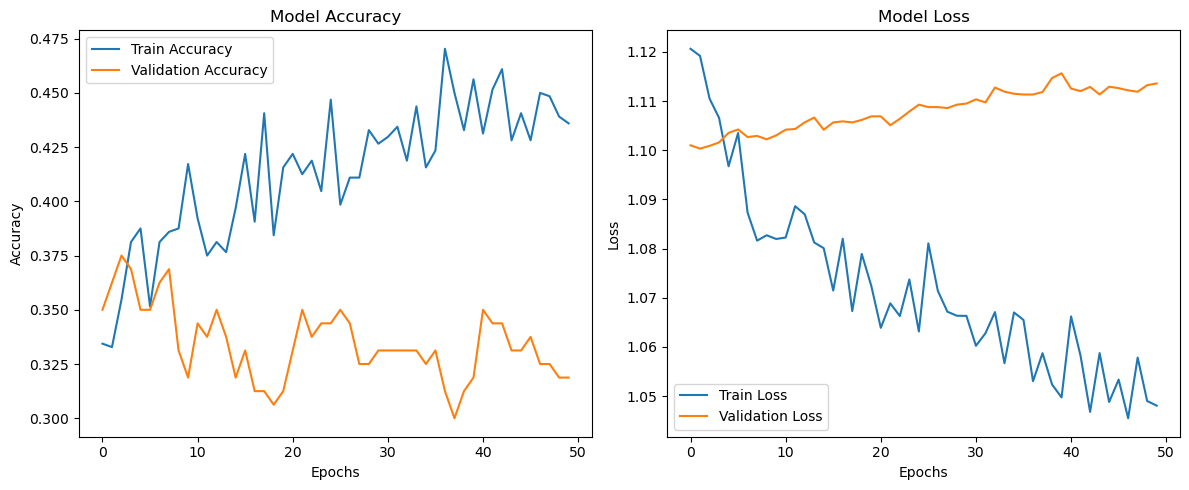

Model Size: 2691 parameters
You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Step 1: Create a synthetic dataset
np.random.seed(42)
num_samples = 1000

data = {
    'soil_texture': np.random.choice(['sandy', 'loamy', 'clayey'], size=num_samples),
    'pH': np.random.uniform(4.0, 8.5, size=num_samples),
    'moisture_content': np.random.uniform(0.1, 30.0, size=num_samples),
    'organic_matter': np.random.uniform(0.5, 5.0, size=num_samples),
    'bulk_density': np.random.uniform(1.0, 1.8, size=num_samples),
    'soil_type': np.random.choice(['sandy', 'loamy', 'clayey'], size=num_samples)
}

df = pd.DataFrame(data)

# Introduce some missing values
for col in df.columns[:-1]:
    df.loc[df.sample(frac=0.1).index, col] = np.nan

# Step 1: Data Preprocessing
# Handle missing data
imputer = SimpleImputer(strategy='mean')

# Encode categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Scale numerical features
scaler = StandardScaler()

# Separate features and labels
X = df.drop(columns=['soil_type'])
y = df['soil_type']

# Column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('impute', imputer), ('scale', scaler)]), ['pH', 'moisture_content', 'organic_matter', 'bulk_density']),
        ('cat', encoder, ['soil_texture'])
    ]
)

X_processed = preprocessor.fit_transform(X)

# Encode labels
y_encoded = pd.Categorical(y).codes

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_encoded, test_size=0.2, random_state=42)

# Step 3: Build the Deep Learning Model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Step 4: Compile the Model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Step 5: Train the Model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Step 6: Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {accuracy:.2f}')

# Classification Report
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred, target_names=['sandy', 'loamy', 'clayey']))

# Step 7: Visualize Training and Validation Accuracy
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Step 8: Save and Load the Model
model.save('soil_classification_model.h5')
loaded_model = tf.keras.models.load_model('soil_classification_model.h5')

# Step 9: Model Size
model_size = sum([np.prod(v.shape) for v in model.trainable_variables])
print(f'Model Size: {model_size} parameters')

# Visualize Model Architecture
tf.keras.utils.plot_model(model, show_shapes=True, to_file="model_architecture.png")

In [1]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.
